# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.calibration import CalibratedClassifierCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
# we are forming a dataset with 100000 points
filtered_data=filtered_data.sample(n=100000, random_state=1)

In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(86847, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.847

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(86846, 10)


1    73352
0    13494
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!
I paid way more for this than the current sale price at my local pet store ($26).  My bull terrier puppy had surgery yesterday and we were struggling to find something to turn his attention away from the stitches.  I put treats through the other side and only put one of the treat balls on the one end, saving the second for later.  He did manage to finally dislodge the treat, but even eating that took longer than his Booda Bimples.  So overall I'm very happy.  After he finished the treat on the outside, he had to find a way to get the other treats on the inside.  He's a 50# bull terrier

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books & songs when I did my  student teaching for preschoolers & turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &  2.  The tradition lives on!
I paid way more for this than the current sale price at my local pet store ($26).  My bull terrier puppy had surgery yesterday and we were struggling to find something to turn his attention away from the stitches.  I put treats through the other side and only put one of the treat balls on the one end, saving the second for later.  He did manage to finally dislodge the treat, but even eating that took longer than his Booda Bimples.  So overall I'm very happy.  After he finished the treat on the outside, he had to find a way to get the other treats on the inside.  He's a 50# bull terrier puppy, and 

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Received this as a holiday gift, if you are in love with rum you should like this cake. It is nice and moist and has a pungent aroma of rum. It is made in the Cayman Islands. My dog was at first, slightly repelled by the smell but now it is following me around!


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children  &amp;    The tradition lives on!


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Received this as a holiday gift if you are in love with rum you should like this cake It is nice and moist and has a pungent aroma of rum It is made in the Cayman Islands My dog was at first slightly repelled by the smell but now it is following me around 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████| 86846/86846 [01:55<00:00, 752.97it/s]


In [24]:
preprocessed_reviews[1500]

'received holiday gift love rum like cake nice moist pungent aroma rum made cayman islands dog first slightly repelled smell following around'

In [25]:
score=final['Score'].values

# [4] Featurization

## [4.3] TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(use_idf = True)
tfidf_results = tf_idf_vect.fit_transform(preprocessed_reviews)


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

In [31]:

tfidf_results.shape


(86846, 56153)

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [32]:
# Please write all the code with proper documentation

features = tf_idf_vect.get_feature_names()
# feature weights based on idf score
coef = tf_idf_vect.idf_
# Store features with their idf score in a dataframe
coeff_df = pd.DataFrame({'Features' : features, 'Idf_score' : coef})
coeff_df = coeff_df.sort_values("Idf_score", ascending = True)[:2000]
print("shape of selected features :", coeff_df.shape)
print("Top 5 features :\n\n",coeff_df[0:10])

shape of selected features : (2000, 2)
Top 5 features :

       Features  Idf_score
33192      not   1.617026
28148     like   2.232119
20900     good   2.334541
21367    great   2.414448
34157      one   2.503111
48950    taste   2.531515
55262    would   2.621450
38576  product   2.647602
28802     love   2.664552
18434   flavor   2.710105


### [5.2] Calulation of Co-occurrence matrix

In [33]:
co_occurence_matrix = np.zeros((len(coeff_df), len(coeff_df)))
print(co_occurence_matrix.shape)
data = pd.DataFrame(co_occurence_matrix, index = coeff_df["Features"], columns = coeff_df["Features"])

window_size = 4
for sent in preprocessed_reviews:
    word = sent.split(" ")
    for i, d in enumerate(word):
        for j in range(max(i - window_size, 0), min(i + window_size, len(word))):
            if (word[i] != word[j]):
                    try:
                        data.loc[word[i], word[j]] += 1
                        data.loc[word[j], word[i]] += 1
                    except:
                        pass

(2000, 2000)


In [34]:
data.head()

Features,not,like,good,great,one,taste,would,product,love,flavor,...,toddler,seafood,unsweetened,hated,dipping,greatly,melts,wrote,moisture,wasted
Features,,,,,,,,,,,,,,,,,,,,,
not,0.0,20560.0,12281.0,6743.0,8694.0,14724.0,12234.0,8268.0,4725.0,9729.0,...,63.0,74.0,34.0,60.0,59.0,30.0,76.0,58.0,73.0,127.0
like,20560.0,0.0,4062.0,2516.0,3499.0,9676.0,4536.0,2457.0,1910.0,4161.0,...,24.0,46.0,49.0,15.0,28.0,12.0,31.0,9.0,19.0,28.0
good,12281.0,4062.0,0.0,2490.0,2566.0,6201.0,2691.0,3636.0,1715.0,3902.0,...,24.0,30.0,27.0,7.0,35.0,9.0,12.0,18.0,14.0,15.0
great,6743.0,2516.0,2490.0,0.0,1693.0,5559.0,1835.0,5470.0,2261.0,3817.0,...,45.0,16.0,12.0,8.0,90.0,9.0,21.0,2.0,14.0,6.0
one,8694.0,3499.0,2566.0,1693.0,0.0,1955.0,2362.0,1405.0,1647.0,1821.0,...,15.0,19.0,19.0,43.0,16.0,11.0,0.0,18.0,5.0,24.0


### [5.3] Finding optimal value for number of components (n) to be retained.

components = 10
components = 200
components = 400
components = 600
components = 800
components = 1000
components = 1990


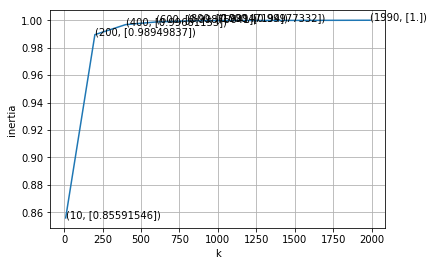

In [35]:
# Please write all the code with proper documentation
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
components = [10,200,400,600,800,1000,1990] 
percentage_explained_varience=[]
for i in components:
    print("components =",i)
    svd = TruncatedSVD(n_components = i)
    svd_final= svd.fit(data)
    explained_varience=np.cumsum(svd_final.explained_variance_ratio_.sum())
    percentage_explained_varience.append(explained_varience)
    
plt.plot(components, percentage_explained_varience,label="percentage_explained_varience")



for xy in zip(components, percentage_explained_varience):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('k')
plt.ylabel('inertia')

plt.show()

    

In [36]:
# Using elbow method we considered optimal number of components as 400.
svd = TruncatedSVD(n_components = 400)
svd_final= svd.fit_transform(data)
    

### [5.4] Applying k-means clustering

for k = 1
for k = 3
for k = 5
for k = 11
for k = 21
for k = 51

The optimal alpha is . 51


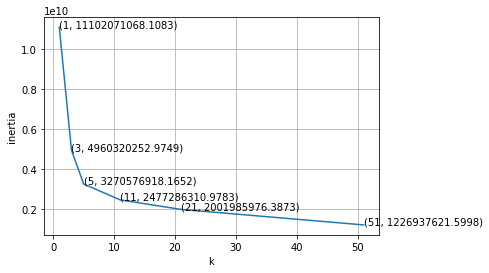

In [38]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
cluster =  [1,3,5,11,21,51]
inertia=[]
for k in cluster:
    print("for k =", k)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(svd_final)
    inertia.append(kmeans.inertia_)
    





optimal_k = cluster[inertia.index(min(inertia))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(cluster, inertia,label="inertia")



for xy in zip(cluster, np.round(inertia,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('k')
plt.ylabel('inertia')

plt.show()




In [47]:
# The optimal number of clusters are 51.
kmeans_svd = KMeans(n_clusters=optimal_k, random_state=0).fit(svd_final)

In [40]:
data["Cluster_labels"] = kmeans_svd.labels_
data["Words"] = coeff_df["Features"].values     
data.head()

Features,not,like,good,great,one,taste,would,product,love,flavor,...,unsweetened,hated,dipping,greatly,melts,wrote,moisture,wasted,Cluster_labels,Words
Features,,,,,,,,,,,,,,,,,,,,,
not,0.0,20560.0,12281.0,6743.0,8694.0,14724.0,12234.0,8268.0,4725.0,9729.0,...,34.0,60.0,59.0,30.0,76.0,58.0,73.0,127.0,2,not
like,20560.0,0.0,4062.0,2516.0,3499.0,9676.0,4536.0,2457.0,1910.0,4161.0,...,49.0,15.0,28.0,12.0,31.0,9.0,19.0,28.0,4,like
good,12281.0,4062.0,0.0,2490.0,2566.0,6201.0,2691.0,3636.0,1715.0,3902.0,...,27.0,7.0,35.0,9.0,12.0,18.0,14.0,15.0,6,good
great,6743.0,2516.0,2490.0,0.0,1693.0,5559.0,1835.0,5470.0,2261.0,3817.0,...,12.0,8.0,90.0,9.0,21.0,2.0,14.0,6.0,14,great
one,8694.0,3499.0,2566.0,1693.0,0.0,1955.0,2362.0,1405.0,1647.0,1821.0,...,19.0,43.0,16.0,11.0,0.0,18.0,5.0,24.0,31,one


### [5.5] Wordclouds of clusters obtained in the above section

total number of word in cluster 1 is 2


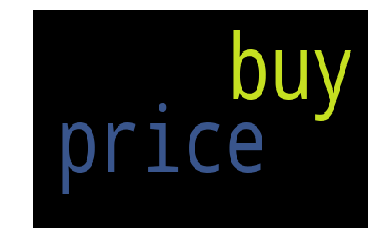

total number of word in cluster 3 is 69


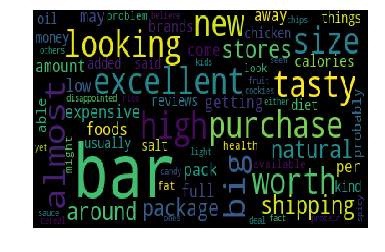

total number of word in cluster 5 is 1


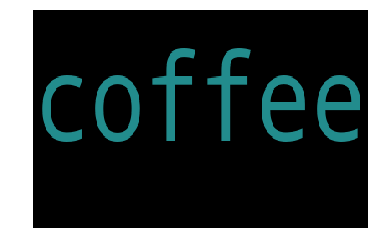

total number of word in cluster 21 is 1


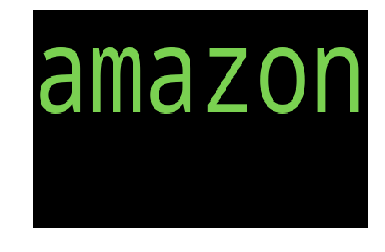

total number of word in cluster 20 is 1


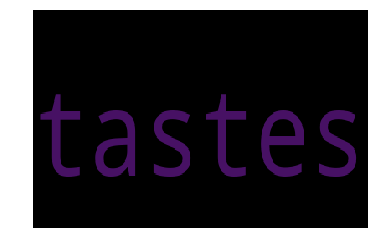

In [43]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import numpy as np
import matplotlib.pyplot as plt
clusters=[1,3,5,21,20]
for i in clusters:
    l = list()
    # Groups each label
    label = data.groupby(["Cluster_labels"]).groups[i]
    for j in range(len(label)):
        l.append(data.loc[label[j]]["Words"])
    print("total number of word in cluster {} is {}".format(i, len(label)))
    string = " ".join(word for word in l)
    word_cloud = WordCloud(relative_scaling = 1.0).generate(string)
    plt.imshow(word_cloud,aspect='auto')
    plt.axis('off')
    plt.show()


The cluster 1 has only two words buy and price

The cluster 3 has 69 words with important words as bar,looking,excellent etc.

The cluster 5 has only one word coffee.

The cluster 21 talks about the word amazon.

### [5.6] Function that returns most similar words for a given word.

In [92]:
##Storing all the features in a list
features_list=coeff_df['Features'].tolist()

In [93]:
# Please write all the code with proper documentation
from sklearn.metrics import pairwise_distances
def similarity(word,count):
    index=features_list.index(word)
    dist = pairwise_distances(svd_final, svd_final[index].reshape(1,400))
    indices = np.argsort(dist.flatten())[0:count]
#print(indices)
    # Sort distances 
    pdist = np.sort(dist.flatten())[0:count]
#print(pdist)
    # put indices at particular index of dataframe
    data_indices = list(data.index[indices])
#print(df_indices)
    print("Most_Similar Words \t Distances")
    # Loop through indices and find match
    for i in range(len(indices)): 
    
        print(data_indices[i], "\t\t\t",pdist[i])

In [94]:
# We are showing 10 similar words close to the word found.
similarity('found',10)

Most_Similar Words 	 Distances
found 			 0.0
bought 			 2640.1400288026753
since 			 2755.688089847382
used 			 2834.38778027319
brand 			 2873.2646784194053
order 			 2889.390945050814
got 			 2890.113588169907
always 			 2895.533589613338
made 			 2903.8593343855505
buying 			 2948.0316886946757


In [95]:
# We are showing 10 similar words close to the word buying.
similarity('buying',10)

Most_Similar Words 	 Distances
buying 			 0.0
purchase 			 1352.0851954934203
see 			 1569.1203875806143
going 			 1707.271476357515
however 			 1717.604253491528
available 			 1721.1798278382341
getting 			 1726.2221574775301
ordered 			 1778.2875023542745
around 			 1784.9095038398686
expensive 			 1812.7362119520092


# [6] Conclusions

In [50]:

# Also please do mention the optimal values that you obtained for number of components & number of clusters.
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["no of components in SVD", "number of clusters in k-means"]
x.add_row([400, 51])
print(x)
 

+-------------------------+-------------------------------+
| no of components in SVD | number of clusters in k-means |
+-------------------------+-------------------------------+
|           400           |               51              |
+-------------------------+-------------------------------+
